## Препроцессинг данных

__Папка с данными на gdrive__

https://drive.google.com/drive/folders/1FeUwrVfxp09xAifiMngwtfrRZ8nhtj8T?usp=sharing


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from matplotlib import pyplot as plt
from matplotlib import colors
from os import listdir
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from snippets import *

%matplotlib inline

In [2]:
DATA_PATH = "../../data"

GPS_PATH = f"{DATA_PATH}/gps_data_raw.csv"
ACCEL_PATH = f"{DATA_PATH}/accel_data_raw.csv"

listdir(DATA_PATH)

['data_good_right_dates',
 'drivers_stats.csv',
 'gps_data.csv',
 'unlabeled',
 'gps_data_raw.csv',
 'matched_routs.csv',
 'good_data',
 'matched_data.csv',
 'points_stats.csv',
 'accel_data.csv',
 'accel_data_raw.csv',
 'drivers_with_gps_and_sl_problems',
 'accel_data_outlier.csv',
 'gps_stats.csv',
 'rides_of_drivers.csv',
 'accel_stats.csv',
 'gps_data_outlier.csv']

## Датасет GPS

In [3]:
df_gps = pd.read_csv(GPS_PATH, parse_dates=[0, 3])
describe(df_gps)

,dtypes,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],5050292,2020-07-31 17:37:31.378776832,2015-03-01 03:00:02,2020-11-20 07:07:20.750000128,2021-03-05 11:16:20,2021-06-03 21:19:25.750000128,2021-08-28 02:47:58,NaN
lat,float64,5.05029e+06,55.743,42.98,55.6674,55.7496,55.8242,82.4343,0.171211
lon,float64,5.05029e+06,37.6021,26.1013,37.5009,37.5848,37.7032,135.46,0.401377
gps_time,datetime64[ns],5050292,2020-07-31 17:37:28.866648576,2015-03-01 03:00:02,2020-11-20 07:07:20.750000128,2021-03-05 11:16:20,2021-06-03 21:19:25.750000128,2021-08-28 02:47:58,NaN
driver_hash,int64,5.05029e+06,3.03558e+17,-9.21858e+18,-4.06958e+18,1.02237e+17,4.79299e+18,9.20647e+18,5.27957e+18
fraud,int64,5.05029e+06,-0.767609,-1,-1,-1,-1,1,0.470076


(5050292, 6)

## Датасет акселерометра

In [4]:
df_accel = pd.read_csv(ACCEL_PATH, parse_dates=[0])
describe(df_accel)

,dtypes,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],2172989,2020-11-22 12:54:59.277889792,2015-02-28 05:46:42.832594,2020-12-18 06:53:34.205120,2021-03-18 16:54:00.549220096,2021-06-12 11:02:18.664983040,2021-08-29 00:03:16.287344,NaN
x,float64,2.17299e+06,0.368934,-71.1054,-0.371101,0.184359,0.785298,65.1529,2.36914
y,float64,2.17299e+06,7.6569,-74.7916,7.63271,8.85376,9.50019,55.2294,3.4034
z,float64,2.17299e+06,3.83295,-65.5062,2.01402,3.69992,5.35365,76.4756,2.73072
lat,float64,2.17299e+06,55.7482,55.3163,55.6768,55.7512,55.8214,82.4343,0.16893
lon,float64,2.17299e+06,37.601,36.3143,37.5016,37.5863,37.686,108.856,0.376061
driver_hash,int64,2.17299e+06,-1.12657e+17,-9.21858e+18,-4.47912e+18,-4.14168e+17,4.43147e+18,9.20647e+18,5.3536e+18
fraud,int64,2.17299e+06,-0.796897,-1,-1,-1,-1,1,0.509161


(2172989, 8)

In [5]:
calc_distance = np.vectorize(haversine_approx)

def make_preprocessing(df, time_col, prefix):
    col_delta = f"{prefix}_delta"
    col_distance = f"{prefix}_distance"
    col_speed = f"{prefix}_speed"
    col_accel = f"{prefix}_accel"
    col_outlier = f"{prefix}_outlier"
    col_staying = f"{prefix}_staying"
    
    df = df.sort_values(by=["driver_hash", time_col]) \
        .drop_duplicates(["lat", "lon", time_col, "driver_hash"]) \
        .copy()

    df[col_delta] = df[time_col].diff().dt.total_seconds().abs()
    df[col_delta].values[0] = df[col_delta].max()

    df[col_distance] = calc_distance(df['lat'], df['lon'], df['lat'].shift(), df['lon'].shift())
    df[col_distance].values[0] = df[col_distance].values[1]

    df[col_speed] = df[col_distance] / df[col_delta]
    df[col_speed] = df[col_speed].fillna(np.inf)

    df_speed = df.groupby(by=["driver_hash", time_col], sort=False) \
        .count()["fraud"] \
        .reset_index() \
        .rename(columns={"fraud": "count"}) \
        .merge(df[["driver_hash", time_col, col_delta, col_distance]], on=["driver_hash", time_col])
    df_speed[col_speed] = df_speed[col_distance] / df_speed["count"]
    df.loc[df[col_delta] == 0.0, col_speed] = df_speed.loc[df_speed[col_delta] == 0.0, col_speed]

    df[col_accel] = df[col_speed].diff() / df[col_delta]
    df[col_accel] = df[col_accel].fillna(np.inf)

    df_speed[col_accel] = df_speed[col_speed] / df_speed["count"]
    df.loc[df[col_delta] == 0.0, col_accel] = df_speed.loc[df_speed[col_delta] == 0.0, col_accel]

    df[col_delta] = df[col_delta].fillna(np.inf).replace(np.inf, 0.0)#.clip(None, 3600)
    df[col_distance] = df[col_distance].round(1)#.replace([np.inf, np.nan], 0.0).clip(None, 3600)
    df[col_speed] = df[col_speed].round(6)#.replace([np.inf, np.nan], 0.0).clip(None, 3600)
    df[col_accel] = df[col_accel].round(6)#.replace([np.inf, np.nan], 0.0).clip(None, 3600)

    df[col_outlier] = 0.0
    mask = ((df[col_distance] > 1000.0) & (df[col_speed] < 5.0)) | ((df[col_delta] > 0.0) & (df[col_speed] > 40.0))
    df.loc[mask, col_outlier] = 1.0
    mask = (df[col_speed] > 0.0) & (df[col_outlier].shift(-1) == 1)
    df.loc[mask, col_outlier] = 1.0

    df[col_staying] = 0.0
    mask = (df[col_outlier] == 0.0) & (df[col_outlier].shift(-1) == 0.0) & (df[col_speed] > 0.0) & (df[col_speed] < 1.0) & (df[col_speed].shift(-1) < 1.0)
    df.loc[mask, col_staying] = 1.0

#     # For GPS data
#     df[col_outlier] = 0.0
#     mask = ((df[col_distance] > 500.0) & (df[col_speed] < 5.0)) | (df[col_speed] > 80.0)
#     df.loc[mask, col_outlier] = 1.0
#     mask = (df[col_speed] > 0.0) & (df[col_outlier].shift(-1) == 1)
#     df.loc[mask, col_outlier] = 1.0

#     df[col_staying] = 0.0
#     mask = (df[col_outlier] == 0) & (df[col_outlier].shift(-1) == 0) & (df[col_speed] > 0.0) & (df[col_speed] < 1.0) & (df[col_speed].shift(-1) < 1.0)
#     df.loc[mask, col_staying] = 1.0

    return df

## Препроцессинг данных GPS, отсортированных по "gps_time"

In [6]:
df_gps = make_preprocessing(df_gps, "gps_time", "gps")

display(df_gps["gps_outlier"].value_counts())
display(df_gps["gps_staying"].value_counts())

0.0    5023321
1.0      12045
Name: gps_outlier, dtype: int64

0.0    4153193
1.0     882173
Name: gps_staying, dtype: int64

## Препроцессинг данных GPS, отсортированных по "time"

In [7]:
df_gps = make_preprocessing(df_gps, "time", "tm")

display(df_gps["tm_outlier"].value_counts())
display(df_gps["tm_staying"].value_counts())

0.0    5001745
1.0      18766
Name: tm_outlier, dtype: int64

0.0    4147180
1.0     873331
Name: tm_staying, dtype: int64

In [27]:
df_gps.to_csv(f"{DATA_PATH}/gps_data_outlier.csv", index=False)
'Done'

'Done'

## Препроцессинг данных акселерометра

In [8]:
df_accel["time"] = df_accel["time"].dt.round("S")
df_accel = make_preprocessing(df_accel, "time", "ac")

display(df_accel["ac_outlier"].value_counts())
display(df_accel["ac_staying"].value_counts())

0.0    1836594
1.0      18810
Name: ac_outlier, dtype: int64

0.0    1772852
1.0      82552
Name: ac_staying, dtype: int64

In [29]:
df_accel.to_csv(f"{DATA_PATH}/accel_data_outlier.csv", index=False)
'Done'

'Done'

## Пример отрисовки маршрута

In [9]:
# [None, -1, 0, 1]
FORCE_FRAUD = None

# Выбор случайного водителя
driver_gps, driver_hash, driver_fraud = sample_driver(df_gps, FORCE_FRAUD)
driver_accel = df_accel[df_accel["driver_hash"] == driver_hash]

center = (driver_gps["lat"].mean(), driver_gps["lon"].mean())
m = folium.Map(location=center, zoom_start=10, legend=True)

# Маршрут по данным  GPS
driver_gps = driver_gps.sort_values(by="gps_time").reset_index(drop=True)
map_driver_points(m, driver_gps, driver_hash, label="gps", color="blue")

# Маршрут по данным акселерометра
driver_accel = driver_accel.sort_values(by="time").reset_index(drop=True)
map_driver_points(m, driver_accel, driver_hash, label="accel")

# # Точки остановок по gps_time
# driver_staying = driver_gps[driver_gps["gps_staying"] == 1.0]
# s = np.round(driver_staying.shape[0]/driver_gps.shape[0] * 100, 2)
# fg = folium.FeatureGroup(f"gps_staying {s}% from {driver_gps.shape[0]}").add_to(m)

# # Точки остановок по time
# driver_staying = driver_gps[driver_gps["tm_staying"] == 1.0]
# s = np.round(driver_staying.shape[0]/driver_gps.shape[0] * 100, 2)
# fg = folium.FeatureGroup(f"tm_staying {s}% from {driver_gps.shape[0]}").add_to(m)

# # Точки остановок по ac_time
# driver_staying = driver_accel[driver_accel["ac_staying"] == 1.0]
# s = np.round(driver_staying.shape[0]/driver_accel.shape[0] * 100, 2)
# fg = folium.FeatureGroup(f"ac_staying {s}% from {driver_accel.shape[0]}").add_to(m)

# Выбросы по gps_time
driver_outlier = driver_gps[driver_gps["gps_outlier"] == 1.0]
p = np.round(driver_outlier.shape[0]/driver_gps.shape[0] * 100, 2)
fg = folium.FeatureGroup(f"gps_outlier {p}% from {driver_gps.shape[0]}").add_to(m)
for i,r in tqdm(driver_outlier.iterrows()):
    folium.Marker((r["lat"], r["lon"]), popup=str(r), icon=folium.Icon(color="red")).add_to(fg)

# Выбросы по gps_time
driver_outlier = driver_gps[driver_gps["tm_outlier"] == 1.0]
p = np.round(driver_outlier.shape[0]/driver_gps.shape[0] * 100, 2)
fg = folium.FeatureGroup(f"tm_outlier {p}% from {driver_gps.shape[0]}").add_to(m)
for i,r in tqdm(driver_outlier.iterrows()):
    folium.Marker((r["lat"], r["lon"]), popup=str(r), icon=folium.Icon(color="red")).add_to(fg)

# Выбросы по ac_time
driver_outlier = driver_accel[driver_accel["ac_outlier"] == 1.0]
p = np.round(driver_outlier.shape[0]/driver_accel.shape[0] * 100, 2)
fg = folium.FeatureGroup(f"ac_outlier {p}% from {driver_accel.shape[0]}").add_to(m)
for i,r in tqdm(driver_outlier.iterrows()):
    folium.Marker((r["lat"], r["lon"]), popup=str(r), icon=folium.Icon(color="red")).add_to(fg)

folium.map.LayerControl('topleft', collapsed= False).add_to(m)
m

36it [00:00, 1158.05it/s]
42it [00:00, 1654.74it/s]
16it [00:00, 1502.06it/s]


## Обзор датасета GPS

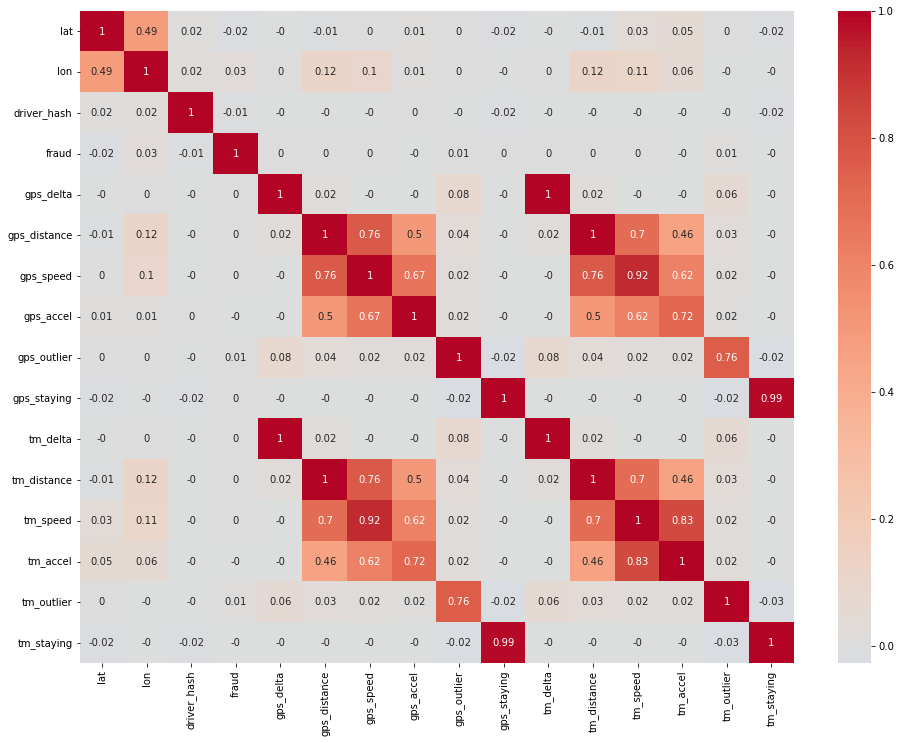

In [10]:
corr = df_gps.corr()

plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap="coolwarm", annot=corr.round(2), center=0)
plt.show()

## Обзор датасета с данными акселерометра

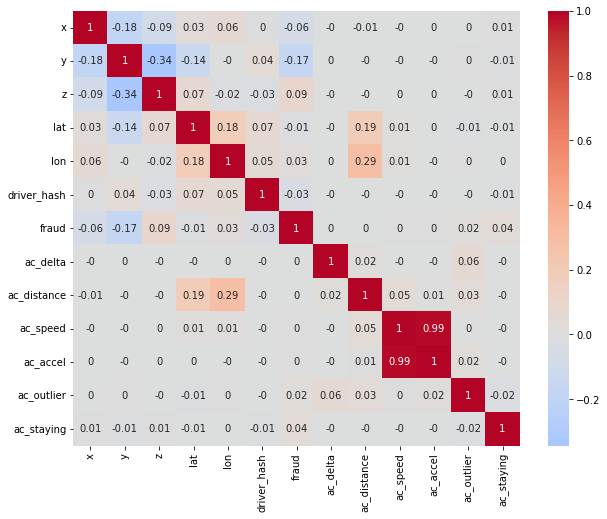

In [11]:
corr = df_accel.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", annot=corr.round(2), center=0)
plt.show()

## Пример отрисовки маршрута

## PCA на данных GPS

In [12]:
def plot_fraud_pca(df, feats, driver_hash, title=""):
    mask = df["fraud"] == -1
    plt.scatter(feats[mask,0], feats[mask,1], color="blue", label="Other", s=100)
    mask = df["fraud"] == 0
    plt.scatter(feats[mask,0], feats[mask,1], color="green", label="Good", s=50, marker="*")
    mask = df["fraud"] == 1
    plt.scatter(feats[mask,0], feats[mask,1], color="red", label="Fraud", s=10, marker="+")
#     mask = df["driver_hash"] == driver_hash
#     plt.scatter(feats[mask,0], feats[mask,1], color="yellow", label=driver_hash)
    plt.legend(loc='upper right')
    plt.title(title)

"GPS by 'gps_time' with Without Scaling"

,lat,lon,gps_delta,gps_distance,gps_speed,gps_outlier
0,-2.186829e-10,7.006394e-10,1.000000,0.000300,-6.336975e-08,1.128870e-08
1,-1.768778e-07,7.787280e-06,-0.000298,0.993914,1.101594e-01,2.922140e-07


"GPS by 'gps_time' with MimMaxScaling"

,lat,lon,gps_delta,gps_distance,gps_speed,gps_outlier
0,0.000108,0.000092,0.002803,0.000737,0.000312,0.999996
1,0.813281,0.581759,-0.000057,0.009406,0.006510,-0.000150


"GPS by 'gps_time' with StandardScaling"

,lat,lon,gps_delta,gps_distance,gps_speed,gps_outlier
0,0.164989,0.277865,0.018734,0.669661,0.666362,0.052296
1,-0.696970,-0.645939,0.012473,0.216851,0.221464,0.027744


"GPS by 'time' with Without Scaling"

,lat,lon,tm_delta,tm_distance,tm_speed,tm_outlier
0,-2.186169e-10,7.008031e-10,1.000000,0.00030,-6.661472e-08,1.127350e-08
1,-1.551773e-07,7.799795e-06,-0.000297,0.99125,1.319946e-01,3.105225e-07


"GPS by 'time' with MimMaxScaling"

,lat,lon,tm_delta,tm_distance,tm_speed,tm_outlier
0,0.000107,-0.000005,0.001792,0.000501,0.000217,0.999998
1,0.813255,0.581756,-0.000038,0.009439,0.009299,-0.000091


"GPS by 'time' with StandardScaling"

,lat,lon,tm_delta,tm_distance,tm_speed,tm_outlier
0,0.242119,0.344970,0.017691,0.638580,0.641966,0.046436
1,-0.675148,-0.611033,0.016537,0.299803,0.281678,0.036278


  0%|          | 0/6 [00:00<?, ?it/s]

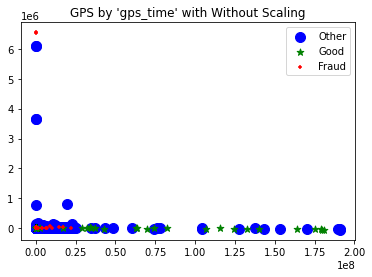

 17%|█▋        | 1/6 [00:11<00:56, 11.26s/it]

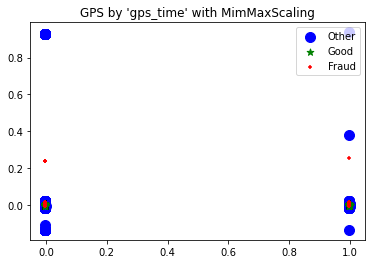

 33%|███▎      | 2/6 [00:23<00:46, 11.60s/it]

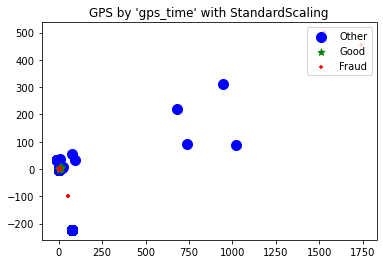

 50%|█████     | 3/6 [00:34<00:34, 11.62s/it]

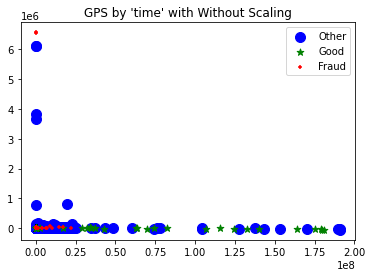

 67%|██████▋   | 4/6 [00:46<00:23, 11.51s/it]

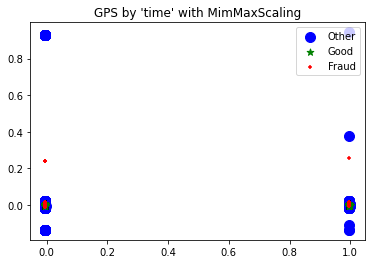

 83%|████████▎ | 5/6 [00:57<00:11, 11.40s/it]

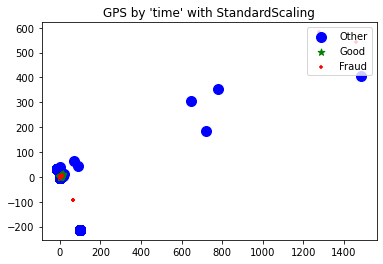

100%|██████████| 6/6 [01:08<00:00, 11.43s/it]


In [22]:
np.random.seed(100)

feats_history = []

X = df_gps[[
    "lat",
    "lon", 
    "gps_delta", 
    "gps_distance", 
    "gps_speed", 
#     "gps_accel",
    "gps_outlier",
#     "gps_staying"
]].copy().replace([np.inf, np.nan], 0.0)

# Without Scaling
pca = PCA(n_components=2)
feats = pca.fit_transform(X)
feats_history.append(pd.DataFrame(feats, columns=["gps_time", "Without Scaling"]))
display(f"GPS by '{feats_history[-1].columns[0]}' with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))

# MinMaxScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(MinMaxScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["gps_time", "MimMaxScaling"]))
display(f"GPS by '{feats_history[-1].columns[0]}' with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))

# StandardScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(StandardScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["gps_time", "StandardScaling"]))
display(f"GPS by '{feats_history[-1].columns[0]}' with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))


X = df_gps[[
    "lat",
    "lon", 
    "tm_delta", 
    "tm_distance", 
    "tm_speed", 
#     "tm_accel",
    "tm_outlier",
#     "tm_staying"
]].copy().replace([np.inf, np.nan], 0.0)

# Without Scaling
pca = PCA(n_components=2)
feats = pca.fit_transform(X)
feats_history.append(pd.DataFrame(feats, columns=["time", "Without Scaling"]))
display(f"GPS by '{feats_history[-1].columns[0]}' with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))

# MinMaxScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(MinMaxScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["time", "MimMaxScaling"]))
display(f"GPS by '{feats_history[-1].columns[0]}' with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))

# StandardScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(StandardScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["time", "StandardScaling"]))
display(f"GPS by '{feats_history[-1].columns[0]}' with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))

# plt.figure(figsize=(16,16))
i = 221
for feats in tqdm(feats_history):
#     plt.subplot(i)
    title = f"GPS by '{feats.columns[0]}' with {feats.columns[1]}"
    plot_fraud_pca(df_gps, feats.values, driver_hash, title)
    i += 1
    plt.show()

# Подбор фич

In [ ]:
df_gps = pd.read_csv(f"{DATA_PATH}/gps_data.csv", parse_dates=[0, 3])
describe(df_gps)

In [ ]:
df_accel = pd.read_csv(f"{DATA_PATH}/accel_data.csv", parse_dates=[0])
describe(df_accel)

'GPS with MimMaxScaling'

,lat,lon,gps_delta,gps_distance,gps_speed,gps_accel,diff_time,diff_distance,diff_speed,diff_accel,tm_delta,tm_distance,tm_speed,tm_accel,sins_gps_accel,cosc_gps_accel,sins_tm_accel,cosc_tm_accel
0,-0.000195,-0.000128,-0.003301,0.011366,0.457209,0.045488,0.000165,0.003075,0.346366,0.072763,-0.003881,0.014391,0.797008,0.118279,-0.029791,0.037492,-0.048043,0.097174
1,0.000339,0.000007,0.004650,-0.016766,-0.650236,-0.145223,0.002896,0.006850,0.706549,0.190536,0.004029,-0.010026,0.057254,0.020551,0.006661,-0.123996,-0.029749,0.010401


'GPS with StandardScaling'

,lat,lon,gps_delta,gps_distance,gps_speed,gps_accel,diff_time,diff_distance,diff_speed,diff_accel,...,sins_tm_accel,cosc_tm_accel,sum_gps_accel,sin_gps_accel,cos_gps_accel,sum_sin_gps_accel,sum_cos_gps_accel,sum_tm_accel,sin_tm_accel,cos_tm_accel
0,-0.001503,-0.000017,0.055366,0.106789,0.329195,0.294877,0.019357,0.052875,0.245521,0.128708,...,-0.267048,0.399844,-0.054910,0.031824,-0.044425,0.047225,-0.038684,0.051187,0.014266,-0.038355
1,-0.014566,-0.029301,0.183425,0.179690,0.003001,-0.014120,0.062375,0.044007,0.027576,0.030787,...,-0.017720,0.001462,0.528971,0.010152,0.004591,-0.524956,0.493313,-0.240969,0.008912,0.005641


100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


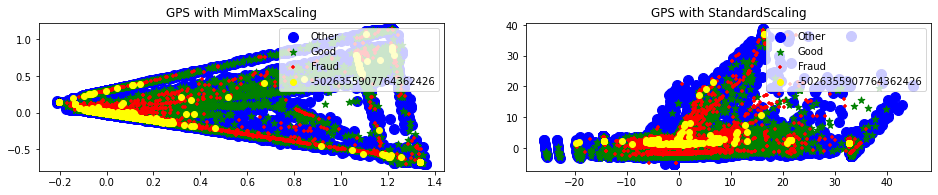

In [38]:
np.random.seed(100)

feats_history = []

X = df_gps[[
    "lat",
    "lon", 
    "gps_delta",
    "gps_distance",
    "gps_speed",
    "gps_accel",
    "gps_outlier",
    "gps_staying",
    "diff_time",
    "diff_distance",
    "diff_speed",
    "diff_accel",
    "tm_delta",
    "tm_distance",
    "tm_speed",
    "tm_accel",
    "tm_outlier",
    "tm_staying",
]].copy().fillna(0.0).replace(np.inf, 0.0)
# X["sum_gps_accel"] = np.cumsum(X["gps_accel"])
# X["sin_gps_accel"] = np.sin(X["gps_accel"])
# X["cos_gps_accel"] = np.cos(X["gps_accel"])
X["sins_gps_accel"] = np.sin(X["gps_accel"]) * X["gps_accel"]
X["cosc_gps_accel"] = np.cos(X["gps_accel"]) * X["gps_accel"]
# X["sum_sin_gps_accel"] = np.cumsum(np.sin(X["gps_accel"]) * X["gps_accel"])
# X["sum_cos_gps_accel"] = np.cumsum(np.cos(X["gps_accel"]) * X["gps_accel"])

# X["sum_tm_accel"] = np.cumsum(X["tm_accel"])
# X["sin_tm_accel"] = np.sin(X["tm_accel"])
# X["cos_tm_accel"] = np.cos(X["tm_accel"])
X["sins_tm_accel"] = np.sin(X["tm_accel"]) * X["tm_accel"]
X["cosc_tm_accel"] = np.cos(X["tm_accel"]) * X["tm_accel"]
# X["sum_sin_tm_accel"] = np.cumsum(np.sin(X["tm_accel"]) * X["tm_accel"])
# X["sum_cos_tm_accel"] = np.cumsum(np.cos(X["tm_accel"]) * X["tm_accel"])

# MinMaxScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(MinMaxScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["all", "MimMaxScaling"]))
display(f"GPS with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))

X["sum_gps_accel"] = np.cumsum(X["gps_accel"])
X["sin_gps_accel"] = np.sin(X["gps_accel"])
X["cos_gps_accel"] = np.cos(X["gps_accel"])
# X["sin_gps_accel"] = np.sin(X["gps_accel"])
# X["cos_gps_accel"] = np.cos(X["gps_accel"])
X["sum_sin_gps_accel"] = np.cumsum(np.sin(X["gps_accel"]) * X["gps_accel"])
X["sum_cos_gps_accel"] = np.cumsum(np.cos(X["gps_accel"]) * X["gps_accel"])

X["sum_tm_accel"] = np.cumsum(X["tm_accel"])
X["sin_tm_accel"] = np.sin(X["tm_accel"])
X["cos_tm_accel"] = np.cos(X["tm_accel"])
# X["sin_tm_accel"] = np.sin(X["tm_accel"])
# X["cos_tm_accel"] = np.cos(X["tm_accel"])
# X["sum_sin_tm_accel"] = np.cumsum(np.sin(X["tm_accel"]) * X["tm_accel"])
# X["sum_cos_tm_accel"] = np.cumsum(np.cos(X["tm_accel"]) * X["tm_accel"])

# StandardScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(StandardScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["all", "StandardScaling"]))
display(f"GPS with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))


plt.figure(figsize=(16,6))
i = 221
for feats in tqdm(feats_history):
    plt.subplot(i)
    title = f"GPS with {feats.columns[1]}"
    plot_fraud_pca(df_gps, feats.values, driver_hash, title)
    i += 1
plt.show()

## PCA на данных акселерометра

'Accel with MimMaxScaling'

,lat,lon,x,y,z,ac_delta,ac_distance,ac_speed,ac_accel,sins_ac_accel,cosc_ac_accel
0,0.000106,0.000124,0.000071,-0.000240,0.001258,0.012662,0.001266,-0.935259,-0.305430,0.035491,-0.174871
1,0.000178,0.000041,0.000151,0.000497,0.001287,0.010923,0.004479,-0.319504,0.513764,-0.147719,0.782305


'Accel with StandardScaling'

,lat,lon,x,y,z,ac_delta,ac_distance,ac_speed,ac_accel,sins_ac_accel,cosc_ac_accel,sum_ac_accel,sin_ac_accel,cos_ac_accel
0,-0.000394,-0.004927,-0.000470,0.007728,-0.003175,-0.029447,-0.006627,0.201890,0.510191,-0.416066,0.598781,0.014922,-0.169142,0.370753
1,0.028387,0.025504,-0.000158,-0.023627,0.040901,0.111294,-0.022828,-0.399578,-0.354722,-0.431467,-0.034658,0.000012,0.496642,0.513708


100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


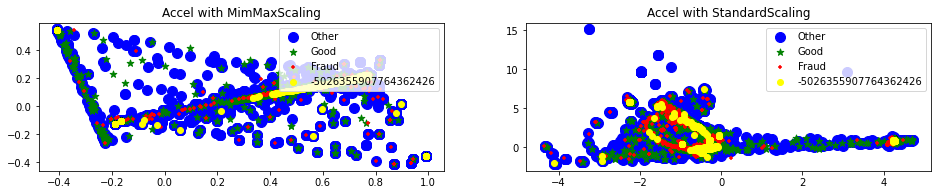

In [31]:
np.random.seed(100)

feats_history = []

X = df_accel[[
    "lat",
    "lon",
    "x",
    "y",
    "z",
    "ac_delta",
    "ac_distance",
    "ac_speed",
    "ac_accel",
]].copy().fillna(0.0)
# X["sum_ac_accel"] = np.cumsum(X["ac_accel"])
# X["sin_ac_accel"] = np.sin(X["ac_accel"])
# X["cos_ac_accel"] = np.cos(X["ac_accel"])
X["sins_ac_accel"] = np.sin(X["ac_accel"]) * X["ac_accel"]
X["cosc_ac_accel"] = np.cos(X["ac_accel"]) * X["ac_accel"]
# X["sum_sin_ac_accel"] = np.cumsum(np.sin(X["ac_accel"]) * X["ac_accel"])
# X["sum_cos_ac_accel"] = np.cumsum(np.cos(X["ac_accel"]) * X["ac_accel"])


# MinMaxScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(MinMaxScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["all", "MimMaxScaling"]))
display(f"Accel with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))

X["sum_ac_accel"] = np.cumsum(X["ac_accel"])
X["sin_ac_accel"] = np.sin(X["ac_accel"])
X["cos_ac_accel"] = np.cos(X["ac_accel"])

# StandardScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(StandardScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["all", "StandardScaling"]))
display(f"Accel with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))


plt.figure(figsize=(16,6))
i = 221
for feats in tqdm(feats_history):
    plt.subplot(i)
    title = f"Accel with {feats.columns[1]}"
    plot_fraud_pca(df_accel, feats.values, driver_hash, title)
    i += 1
plt.show()

'Accel with MimMaxScaling'

,lat,lon,x,y,z,ac_delta,ac_distance,ac_speed,ac_accel,sinc_x,cosc_x,sinc_y,cosc_y,sinc_z,cosc_z,sins_ac_accel,cosc_ac_accel
0,0.000106,0.000124,0.000070,-0.000234,0.001258,0.012661,0.001265,-0.935254,-0.305426,-0.000260,0.000433,0.002794,-0.002163,-0.000153,-0.001316,0.035490,-0.174866
1,0.000178,0.000041,0.000148,0.000499,0.001294,0.010923,0.004477,-0.319490,0.513767,0.000136,0.000580,0.002205,-0.000731,0.000355,-0.001083,-0.147721,0.782304


'Accel with StandardScaling'

,lat,lon,x,y,z,ac_delta,ac_distance,ac_speed,ac_accel,sinc_x,...,sins_ac_accel,cosc_ac_accel,sin_ac_accel,cos_ac_accel,sin_x,cos_x,sin_y,cos_y,sin_z,cos_z
0,0.043917,0.027636,0.089732,-0.286725,0.309014,-0.005575,-0.019615,0.006633,0.005144,0.024208,...,0.001832,-0.000482,-0.001381,-0.007511,0.047095,-0.143686,0.375665,0.409710,-0.240726,0.170060
1,0.010885,0.001366,0.028704,-0.029413,-0.006346,-0.029794,-0.005391,0.205900,0.509232,0.005017,...,-0.409513,0.593887,-0.170898,0.362988,-0.002829,-0.043024,-0.036587,0.037978,0.051637,0.009956


100%|██████████| 2/2 [00:00<00:00,  4.43it/s]


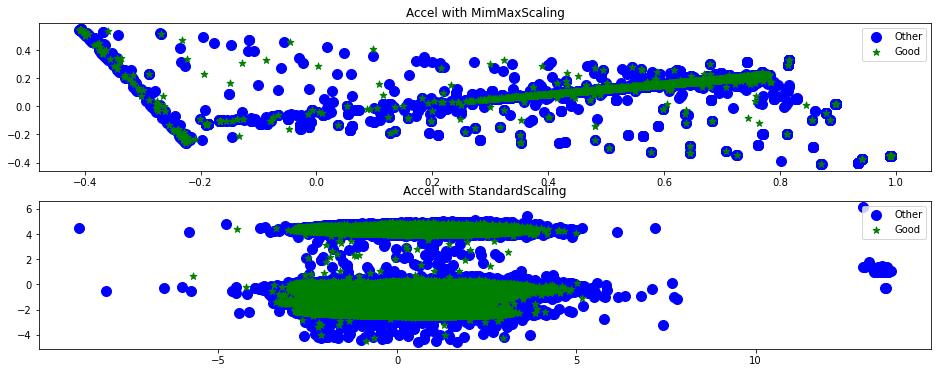

In [45]:
np.random.seed(100)

feats_history = []

X = df_accel[[
    "lat",
    "lon",
    "x",
    "y",
    "z",
    "ac_delta",
    "ac_distance",
    "ac_speed",
    "ac_accel",
]].copy().fillna(0.0)
# X["sum_x"] = np.cumsum(df_accel["x"])
X["sinc_x"] = np.sin(df_accel["x"]) * df_accel["x"]
X["cosc_x"] = np.cos(df_accel["x"]) * df_accel["x"]
# X["sum_sin_ac_x"] = np.cumsum(np.sin(df_accel["x"]) * df_accel["x"])
# X["sum_cos_ac_x"] = np.cumsum(np.cos(df_accel["x"]) * df_accel["x"])

# X["sum_y"] = np.cumsum(df_accel["y"])
X["sinc_y"] = np.sin(df_accel["y"]) * df_accel["y"]
X["cosc_y"] = np.cos(df_accel["y"]) * df_accel["y"]
# X["sum_sin_ac_y"] = np.cumsum(np.sin(df_accel["y"]) * df_accel["y"])
# X["sum_cos_ac_y"] = np.cumsum(np.cos(df_accel["y"]) * df_accel["y"])

# X["sum_z"] = np.cumsum(df_accel["z"])
X["sinc_z"] = np.sin(df_accel["z"]) * df_accel["z"]
X["cosc_z"] = np.cos(df_accel["z"]) * df_accel["z"]
# X["sum_sin_ac_z"] = np.cumsum(np.sin(df_accel["z"]) * df_accel["z"])
# X["sum_cos_ac_z"] = np.cumsum(np.cos(df_accel["z"]) * df_accel["z"])

# X["sum_ac_accel"] = np.cumsum(X["ac_accel"])
# X["sin_ac_accel"] = np.sin(X["ac_accel"])
# X["cos_ac_accel"] = np.cos(X["ac_accel"])
X["sins_ac_accel"] = np.sin(X["ac_accel"]) * X["ac_accel"]
X["cosc_ac_accel"] = np.cos(X["ac_accel"]) * X["ac_accel"]
# X["sum_sin_ac_accel"] = np.cumsum(np.sin(X["ac_accel"]) * X["ac_accel"])
# X["sum_cos_ac_accel"] = np.cumsum(np.cos(X["ac_accel"]) * X["ac_accel"])


# MinMaxScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(MinMaxScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["all", "MimMaxScaling"]))
display(f"Accel with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))

# X["sum_ac_accel"] = np.cumsum(X["ac_accel"])
X["sin_ac_accel"] = np.sin(X["ac_accel"])
X["cos_ac_accel"] = np.cos(X["ac_accel"])
# X["sum_x"] = np.cumsum(df_accel["x"])
X["sin_x"] = np.sin(df_accel["x"])
X["cos_x"] = np.cos(df_accel["x"])
# X["sum_y"] = np.cumsum(df_accel["y"])
X["sin_y"] = np.sin(df_accel["y"])
X["cos_y"] = np.cos(df_accel["y"])
# X["sum_z"] = np.cumsum(df_accel["z"])
X["sin_z"] = np.sin(df_accel["z"])
X["cos_z"] = np.cos(df_accel["z"])

# StandardScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(StandardScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["all", "StandardScaling"]))
display(f"Accel with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))


plt.figure(figsize=(16,6))
i = 211
for feats in tqdm(feats_history):
    plt.subplot(i)
    title = f"Accel with {feats.columns[1]}"
    plot_fraud_pca(df_accel, feats.values, driver_hash, title)
    i += 1
plt.show()